# Infant resting state fMRI preprocessing
This notebook contains preprocessing tailored to infant resting state fMRI collected in 5-8 month olds. 

The processing steps for the fMRI broadly include:
* Slice-time correction
* Rigid realignment
* Co-registration to the sMRI (T2-weighted structural MRI)
* Co-registration to template
* De-noising to remove:
    - Mean timeseries for that voxel
    - Component noise associated with white matter and CSF- delete the GM and smooth what is left
    - Component noise associated with background signal - delete brain and smooth what's left
    - Component noise from the averaged timeseries
    - motion regressors
    - Motion derivatives (lagged 6 times)
    - Squared derivatives (lagged 6 times) as an exploratory
* Bandpass filtering

In [54]:
#import packages
from os import listdir, makedirs
from os.path import isdir
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, FLIRT, BET, Merge, ExtractROI, ApplyTOPUP, TOPUP
from nipype.interfaces.fsl.utils import Reorient2Std, MotionOutliers
from nipype.interfaces.fsl.maths import ApplyMask, MeanImage
from nipype.interfaces.freesurfer import Resample, Binarize
from nipype.algorithms.confounds import CompCor
from nipype.interfaces.nipy.preprocess import Trim
from nipype.interfaces.afni.preprocess import Bandpass
from nipype.interfaces.afni.utils import AFNItoNIFTI
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables

# Set study variables
setup='Cat'
sample='newborn' #6mo or newborn

if setup=='Marissa':
    studyhome = '/Volumes/SEALab_Projects/BABIES/MRI/Newborn_BIDS'  #update if 6-month old
    raw_data = studyhome + '/raw'
    output_dir = studyhome + '/proc/preproc'
    workflow_dir = studyhome + '/workflows' 
    templates = studyhome + '/templates'
elif setup=='Cat':
    studyhome = '/home/camachocm2/Analysis/SEA/rest_proc'
    raw_data = studyhome + '/raw/raw_func'
    output_dir = studyhome + '/processed/preproc'
    workflow_dir = studyhome + '/workflows'
    templates = studyhome + '/templates'
    subjects_info = read_csv(studyhome + '/misc/subject_info.csv',index_col=None, dtype={'subject_id':str})

subjects_list = subjects_info['subject_id'].tolist()
#subjects_list = ['1096']

if sample =='6mo':
    template_brain = templates + '/6mo_T2w_template_2mm.nii.gz'
    template_mask = templates + '/6mo_T2w_template_2mm_mask.nii.gz'
    template_gmmask = studyhome + '/6mo_T2w_template_2mm_gm.nii.gz'
    template_nongm = studyhome + '/6mo_T2w_template_2mm_nongm.nii.gz'
    template_nonbrain = studyhome + '/6mo_T2w_template_2mm_nonbrainD1.nii.gz'
    template_maskD1 = studyhome + '/6mo_T2w_template_2mm_maskD1.nii.gz'
elif sample=='newborn':
    template_brain = templates + '/neonate_T2w_template_2mm.nii.gz'
    template_mask = templates + '/neonate_T2w_template_2mm_mask.nii.gz'
    template_gmmask = templates + '/neonate_T2w_template_2mm_gm.nii.gz'
    template_nongm = templates + '/neonate_T2w_template_2mm_nongm.nii.gz'
    template_nonbrain = templates + '/neonate_T2w_template_2mm_nonbrainD1.nii.gz'
    template_maskD1 = templates + '/neonate_T2w_template_2mm_maskD1.nii.gz'

custom_timings = studyhome + '/misc/SEA_slicetime_trfraction.txt'
phase_encoding_file = studyhome + '/misc/SEA_rest_encoding.txt'

proc_cores = 6 # number of cores of processing for the workflows
interleave=True
TR = 1.41 # in seconds
slice_dir = 3 # 1=x, 2=y, 3=z
resampled_voxel_size = (2,2,2)
fwhm = 4 #fwhm for smoothing with SUSAN
anat_type='t2'

highpass_freq = 0.008 #in Hz
lowpass_freq = 0.09 #in Hz

In [ ]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

## Unwarp EPI images

In [ ]:
def sort_pes(pes):
    from nipype import config, logging
    from nipype.interfaces.fsl import Merge
    from os.path import abspath
    config.enable_debug_mode()
    logging.update_logging(config)
    
    print(pes)
    pe1s = []
    pe0s = []
    for file in pes:
        if 'Fsp' in file:
            pe0s.append(file)
        elif 'Fsa' in file:
            pe1s.append(file)
    
    if len(pe1s) < len(pe0s):
        for a in range(len(pe1s),len(pe0s)):
            pe1s.append(pe1s[0])
    
    pe1s = sorted(pe1s)
    pe0s = sorted(pe0s)

    me = Merge()
    merged_pes = []
    
    for i in range(0,len(pe1s)):
        num=pe1s[i][-12:-11]
        me.inputs.in_files = [pe1s[i],pe0s[i]]
        me.inputs.dimension='t'
        me.inputs.merged_file = 'merged_pes%s.nii.gz' % num
        me.run()
        file = abspath('merged_pes%s.nii.gz' % num)
        merged_pes.append(file)
        
    return(merged_pes)

In [ ]:
 pes_template = {'pes': raw_data + '/%s/*rsEPI_Fs*.nii.gz'}
select_pes = Node(DataGrabber(sort_filelist=True,
                              template = raw_data + '/%s/*rsEPI_Fs*.nii.gz',
                              field_template = pes_template,
                              base_directory=raw_data,
                              infields=['subject_id'], 
                              template_args={'pes':[['subject_id']]}), 
                  name='select_pes')

func_template = {'func': raw_data + '/%s/*rsEPI_Fsp*.nii.gz'}
select_func = Node(DataGrabber(sort_filelist=True,
                               template = raw_data + '/%s/*rsEPI_Fsp*.nii.gz',
                               field_template = func_template,
                               base_directory=raw_data,
                               infields=['subject_id'], 
                               template_args={'func':[['subject_id']]}), 
                   name='select_func')

# include only the first volume of each PE volume
trim_PEs = MapNode(ExtractROI(t_min=0, t_size=5),name='trim_PEs', 
                   iterfield=['in_file'])

sort_pe_list = Node(Function(input_names=['pes'],
                             output_names=['merged_pes'],
                             function=sort_pes), 
                    name='sort_pe_list')

topup = MapNode(TOPUP(encoding_file=phase_encoding_file), name='topup',iterfield=['in_file'])

apply_topup = MapNode(ApplyTOPUP(in_index=[6], encoding_file=phase_encoding_file,
                                 method='jac', out_corrected='func_unwarped.nii.gz'),
                      name='apply_topup',iterfield=['in_topup_fieldcoef','in_topup_movpar','in_files'])

In [ ]:
prepreprocflow = Workflow(name='prepreprocflow')
prepreprocflow.connect([(infosource,select_pes, [('subject_id','subject_id')]),
                        (infosource,select_func, [('subject_id','subject_id')]),
                        (select_pes,trim_PEs, [('pes','in_file')]), 
                        (trim_PEs,sort_pe_list, [('roi_file','pes')]),
                        (sort_pe_list,topup, [('merged_pes','in_file')]),
                        (topup, apply_topup, [('out_fieldcoef','in_topup_fieldcoef'), 
                                              ('out_movpar','in_topup_movpar')]),
                        (select_func, apply_topup, [('func','in_files')]),
                        (apply_topup, datasink, [('out_corrected','unwarped_funcs')])
                       ])

prepreprocflow.base_dir = workflow_dir
prepreprocflow.write_graph(graph2use='flat')
prepreprocflow.run('MultiProc', plugin_args={'n_procs': proc_cores, 'memory_gb':20})

## Preprocess T2w anatomical images
These nodes and workflow (anat_preprocflow) performs N4 bias correction and skullstripping.

In [ ]:
## File handling nodes

template={'anat': raw_data + '/%s*/*T2w*.nii.gz'}
selectfiles = Node(DataGrabber(sort_filelist=True,
                               template = raw_data + '/%s*/*T2w*.nii.gz',
                               field_template = template,
                               base_directory=raw_data,
                               infields=['subject_id'],
                               template_args={'anat':[['subject_id']]}),
                   name='selectfiles')

n4biascorr = Node(N4BiasFieldCorrection(dimension=3,
                                        output_image='{0}_nucorrect.nii.gz'.format(anat_type)), 
                  name='n4biascorr')

skullstrip = Node(BET(out_file='{0}_nucorrect_strip.nii.gz'.format(anat_type)), name='skullstrip')

In [ ]:
anat_preprocflow = Workflow(name='anat_preprocflow')
anat_preprocflow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                          (selectfiles, n4biascorr, [('anat','input_image')]),
                          (n4biascorr, skullstrip, [('output_image','in_file')]),
                          
                          (n4biascorr, datasink, [('output_image','nu_corrected_anat')]),
                          (skullstrip, datasink, [('out_file','skullstripped_anat')])
                         ])

anat_preprocflow.base_dir = workflow_dir
anat_preprocflow.write_graph(graph2use='flat')
anat_preprocflow.run('MultiProc', plugin_args={'n_procs': 10, 'memory_gb':30})

## Preprocess fMRI resting state data
These nodes and workflow (preprocflow) perform basic preprocessing to align the functional volumes into a common space.
1. Reorient images to standard space
2. Reslice the structural image to 2mm isotropic
3. Functional image slice time correction
4. Rigid realignment to first volume of functional image
5. Coregistration of functional images to structural image
6. Coregistration of functional images to template image
7. Trim first 4 volumes of the functional images to remove pre-steady-state images

In [ ]:
## File handling Nodes

# Data grabber- select sMRI
anat_template = {'struct': output_dir + '/skullstripped_anat/{subject_id}/t2_nucorrect_strip.nii.gz'}
selectanat = Node(SelectFiles(anat_template), name='selectfiles')

# Data grabber- select fMRI
func_template = {'func':output_dir + '/unwarped_funcs/%s/*/func_unwarped.nii.gz'}
selectfunc = Node(DataGrabber(sort_filelist=True,
                              template = output_dir + '/unwarped_funcs/%s/*/func_unwarped.nii.gz',
                              field_template = func_template,
                              base_directory=raw_data,
                              infields=['subject_id'], 
                              template_args={'func':[['subject_id']]}), name='selectfunc')

In [ ]:
# Data QC nodes
def create_coreg_plot(epi,anat):
    import os
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn import plotting
    from nipype.interfaces.nipy.preprocess import Trim
    from os.path import abspath
    
    tr = Trim()
    tr.inputs.in_file = epi[0]
    tr.inputs.end_index = 1
    tr.inputs.out_file = 'firstvol.nii.gz'
    tr.run()
    
    epi = abspath('firstvol.nii.gz')
    
    coreg_filename='coregistration.png'
    display = plotting.plot_anat(epi, display_mode='ortho',
                                 draw_cross=False,
                                 title = 'coregistration to anatomy')
    display.add_edges(anat)
    display.savefig(coreg_filename) 
    display.close()
    coreg_file = os.path.abspath(coreg_filename)
    
    return(coreg_file)

def check_mask_coverage(epi,brainmask):
    import os
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn import plotting
    
    from nipype.interfaces.nipy.preprocess import Trim
    from os.path import abspath
    
    tr = Trim()
    tr.inputs.in_file = epi[0]
    tr.inputs.end_index = 1
    tr.inputs.out_file = 'firstvol.nii.gz'
    tr.run()
    
    epi = abspath('firstvol.nii.gz')
    
    maskcheck_filename='maskcheck.png'
    display = plotting.plot_anat(epi, display_mode='ortho',
                                 draw_cross=False,
                                 title = 'brainmask coverage')
    display.add_contours(brainmask,levels=[.5], colors='r')
    display.savefig(maskcheck_filename)
    display.close()
    maskcheck_file = os.path.abspath(maskcheck_filename)

    return(maskcheck_file)

make_coreg_img = Node(name='make_coreg_img',
                      interface=Function(input_names=['epi','anat'],
                                         output_names=['coreg_file'],
                                         function=create_coreg_plot))

make_checkmask_img = Node(name='make_checkmask_img',
                      interface=Function(input_names=['epi','brainmask'],
                                         output_names=['maskcheck_file'],
                                         function=check_mask_coverage))

make_checkmask_img.inputs.brainmask = template_gmmask

In [ ]:
## Nodes for preprocessing

# Reorient to standard space using FSL
reorientfunc = MapNode(Reorient2Std(), name='reorientfunc', iterfield=['in_file'])
reorientstruct = Node(Reorient2Std(), name='reorientstruct')

# Reslice- using MRI_convert 
reslice_struct = Node(Resample(voxel_size=resampled_voxel_size), name='reslice_struct')

#Slice timing correction based on interleaved acquisition using FSL
slicetime_correct = MapNode(SliceTimer(interleaved=interleave, 
                                       custom_timings=custom_timings,
                                       time_repetition=TR, 
                                       out_file='st_func.nii.gz'),
                            name='slicetime_correct', iterfield=['in_file'])
# Rigid realignment
realign = MapNode(MCFLIRT(save_plots=True,out_file='rest_moco.nii.gz'), name='realign', iterfield=['in_file'])

# Registration- using FLIRT
# The BOLD image is 'in_file', the anat is 'reference', the output is 'out_file'
firstvol = MapNode(Trim(end_index=1), name='firstvol',iterfield=['in_file'])
coreg1 = MapNode(FLIRT(), name='coreg1', iterfield=['in_file'])
coreg2 = MapNode(FLIRT(apply_xfm=True), name='coreg2', iterfield=['in_file','in_matrix_file'])

# Registration
register_template = Node(FLIRT(reference=template_brain, 
                               out_file='preproc_anat.nii.gz'), 
                         name='register_template')

xfmFUNC = MapNode(FLIRT(reference=template_brain,apply_xfm=True, out_file='realigned_func.nii.gz'), 
                  name='xfmFUNC', iterfield=['in_file'])

In [ ]:
## Preprocessing Workflow

preprocflow = Workflow(name='preprocflow')
preprocflow.connect([(infosource,selectanat,[('subject_id','subject_id')]), 
                     (infosource,selectfunc,[('subject_id','subject_id')]), 
                     (selectanat,reorientstruct,[('struct','in_file')]),
                     
                     (reorientstruct,reslice_struct,[('out_file','in_file')]),
                     (reslice_struct,coreg1,[('resampled_file','reference')]),
                     (reslice_struct,coreg2,[('resampled_file','reference')]),
                     (reslice_struct,register_template,[('resampled_file','in_file')]),
                     
                     (selectfunc,reorientfunc,[('func','in_file')]),
                     (reorientfunc,slicetime_correct,[('out_file','in_file')]),
                     (slicetime_correct, realign, [('slice_time_corrected_file','in_file')]),
                     (realign,firstvol,[('out_file','in_file')]),
                     (firstvol,coreg1,[('out_file','in_file')]),
                     (realign,coreg2,[('out_file','in_file')]),
                     (coreg1,coreg2,[('out_matrix_file', 'in_matrix_file')]),
                     (register_template,xfmFUNC,[('out_matrix_file','in_matrix_file')]),
                     (coreg2,xfmFUNC,[('out_file','in_file')]),
                     
                     (reorientstruct,make_coreg_img,[('out_file','anat')]),
                     (coreg1,make_coreg_img,[('out_file','epi')]),
                     (xfmFUNC,make_checkmask_img,[('out_file','epi')]),
                     (make_checkmask_img,datasink,[('maskcheck_file','maskcheck_image')]),
                     (make_coreg_img,datasink,[('coreg_file','coreg_image')]),
                   
                     (realign, datasink,[('par_file','motion_parameters')]),
                     (register_template,datasink,[('out_file','proc_struct')]),
                     (xfmFUNC, datasink, [('out_file','registered_func')])
                    ])
preprocflow.base_dir = workflow_dir
preprocflow.write_graph(graph2use='flat')
preprocflow.run('MultiProc', plugin_args={'n_procs': proc_cores})

## Create Nuissance Regressors
These nodes and workflow creates both the subject specific and general nuissance regressors needed for preprocessing the rest data per the process developed by David Montez. 

In [39]:
# Data grabber- select fMRI
func_template = {'func':output_dir + '/registered_func/%s/*/realigned_func.nii.gz'}
selectfunc = Node(DataGrabber(sort_filelist = True,
                              template = output_dir + '/registered_func/%s/*/realigned_func.nii.gz',
                              field_template = func_template,
                              base_directory = output_dir,
                              infields=['subject_id'], 
                              template_args = {'func':[['subject_id']]}), name='selectfunc')

# select motion params
mot_template={'motion':output_dir + '/motion_parameters/%s/*/rest_moco.nii.gz.par'}
selectmotion = Node(DataGrabber(sort_filelist = True,
                                template = output_dir + '/motion_parameters/%s/*/rest_moco.nii.gz.par',
                                field_template = mot_template,
                                base_directory = output_dir,
                                infields = ['subject_id'], 
                                template_args = {'motion':[['subject_id']]}), name='selectmotion')     

In [40]:
def mask_blur_func(mask, in_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from numpy import median, where
    from nipype.interfaces.fsl import ApplyMask
    from glob import glob
    from subprocess import check_call

    applymask = ApplyMask()
    applymask.inputs.mask_file = mask
    applymask.inputs.in_file = in_file
    applymask.inputs.out_file = 'masked_file.nii.gz'
    applymask.inputs.nan2zeros = True
    applymask.run()

    masked_file = abspath('masked_file.nii.gz')
    
    
    if 'nonbrain' in mask:
        check_call(['gunzip',masked_file])
        
        from nipype.interfaces.spm import Smooth
        smooth = Smooth()
        smooth.inputs.in_files = 'masked_file.nii'
        smooth.inputs.fwhm = [22,4,4]
        smooth.inputs.out_prefix = 'blurred_'
        smooth.run()
        check_call(['gzip','blurred_masked_file.nii'])
        
    else:
        from nipype.interfaces.fsl import Smooth
        smooth = Smooth()
        smooth.inputs.in_file = masked_file
        smooth.inputs.smoothed_file = 'blurred_masked_file.nii.gz'
        smooth.inputs.fwhm = 4
        smooth.run()

    blurred_masked_file = abspath('blurred_masked_file.nii.gz')

    return(blurred_masked_file)

def leadlagmatrix(motion_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import numpy as np

    motion_params = np.loadtxt(motion_file, dtype=float)
    trs = motion_params.shape[0]
    params = motion_params.shape[1]
    derivatives = np.gradient(motion_params, axis=0)
    leadlagderivs = np.zeros((trs,params*8))
    derivativessq = derivatives**2
    leadlagderivssq = np.zeros((trs,params*8))

    for i in range(0,params):
        for j in range(0,8):
            leadlagderivs[:,j+params*i] =  np.roll(derivatives[:,i],shift=j, axis=0)
            leadlagderivs[:j,j+params*i] = 0

    for i in range(0,params):
        for j in range(0,8):
            leadlagderivssq[:,j+params*i] =  np.roll(derivativessq[:,i],shift=j, axis=0)
            leadlagderivssq[:j,j+params*i] = 0

    np.savetxt('derivsleadlag.txt', leadlagderivs)
    np.savetxt('derivssqleadlag.txt', leadlagderivssq)

    leadlagderivsmot = abspath('derivsleadlag.txt')
    leadlagderivssqmot = abspath('derivssqleadlag.txt')
    
    return(leadlagderivsmot, leadlagderivssqmot)

In [41]:
# get scanner noise
session_noise = MapNode(Function(input_names=['mask','in_file'], 
                                 output_names=['blurred_masked_file'],
                                 function=mask_blur_func), name='session_noise', iterfield=['in_file'])
session_noise.inputs.mask=template_nonbrain

# get noise associated with WM and CSF
wmcsf_noise = MapNode(Function(input_names=['mask','in_file'], 
                               output_names=['blurred_masked_file'],
                               function=mask_blur_func), name='wmcsf_noise', iterfield=['in_file'])
wmcsf_noise.inputs.mask=template_nongm


# prepare leadlag motion and derivatives
prep_motion = MapNode(Function(input_names=['motion_file'], 
                               output_names=['leadlagderivsmot','leadlagderivssqmot'],
                               function=leadlagmatrix), 
                      name='prep_motion', iterfield=['motion_file'])

In [43]:
create_noise_flow = Workflow(name='create_noise_flow')
create_noise_flow.connect([(infosource,selectfunc,[('subject_id','subject_id')]),
                           (selectfunc, wmcsf_noise, [('func','in_file')]),
                           (selectfunc, session_noise, [('func','in_file')]),
                           (wmcsf_noise, datasink, [('blurred_masked_file','wmcsf_noise_file')]),
                           (session_noise, datasink, [('blurred_masked_file','session_noise_file')]),
                           
                           (infosource,selectmotion,[('subject_id','subject_id')]),
                           (selectmotion, prep_motion, [('motion','motion_file')]),
                           (prep_motion, datasink, [('leadlagderivsmot','leadlagderivsmotion'),
                                                    ('leadlagderivssqmot','leadlagderivs_squaremotion')])
                          ])
create_noise_flow.base_dir = workflow_dir
create_noise_flow.write_graph(graph2use='flat')
create_noise_flow.run('MultiProc', plugin_args={'n_procs': proc_cores})

191210-10:48:46,469 nipype.workflow INFO:
	 Generated workflow graph: /home/camachocm2/Analysis/SEA/rest_proc/workflows/create_noise_flow/graph.png (graph2use=flat, simple_form=True).
191210-10:48:46,485 nipype.workflow INFO:
	 Workflow create_noise_flow settings: ['check', 'execution', 'logging', 'monitoring']
191210-10:48:46,511 nipype.workflow INFO:
	 Running in parallel.
191210-10:48:46,517 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 56.55/56.55, Free processors: 6/6.
191210-10:48:46,806 nipype.workflow INFO:
	 [Node] Setting-up "create_noise_flow.selectfunc" in "/home/camachocm2/Analysis/SEA/rest_proc/workflows/create_noise_flow/_subject_id_1096/selectfunc".
191210-10:48:46,806 nipype.workflow INFO:
	 [Node] Setting-up "create_noise_flow.selectmotion" in "/home/camachocm2/Analysis/SEA/rest_proc/workflows/create_noise_flow/_subject_id_1096/selectmotion".
191210-10:48:46,845 nipype.workflow INFO:
	 [Node] Running "selectmotion" ("nipype.i

### Create mean volume and extract the first 9 principle components

In [ ]:
from glob import glob
from os import mkdir, remove
from os.path import abspath
from nibabel import load, save, Nifti1Image
import numpy as np
from subprocess import check_call

mkdir(output_dir + '/mean_func')
mf_output_dir = output_dir + '/mean_func'

in_files = glob(output_dir + '/registered_func/*/*/realigned_func.nii.gz')
    
image = load(in_files[0])
data = image.get_data()
data = np.expand_dims(data,4)
maxt = data.shape[3]

for a in range(1,len(in_files)):
    tempimg = load(in_files[a])
    tempdata = tempimg.get_data()
    if tempdata.shape[3] > maxt:
        maxt=tempdata.shape[3]

files_to_avg = []        

for a in range(0,len(in_files)):
    tempimg = load(in_files[a])
    tempdata = tempimg.get_data()
    if tempdata.shape[3] < maxt:
        padn=data.shape[3]-tempdata.shape[3]
        tempdata=np.pad(tempdata,pad_width=((0,0),(0,0),(0,0),(0,padn)),
                        mode='constant',constant_values=0)
        new_img = Nifti1Image(tempdata, affine=tempimg.affine, header=tempimg.header)
        save(new_img, 'realigned_func_pad_{0}.nii.gz'.format(a))
        files_to_avg.append(abspath('realigned_func_pad_{0}.nii.gz'.format(a)))
    elif tempdata.shape[3] == maxt:
        files_to_avg.append(in_files[a])
        
mean_file=mf_output_dir+'/mean_funcs.nii.gz'

check_call(['3dMean','-prefix',mean_file,'-non_zero'] +files_to_avg)

In [ ]:
from glob import glob
from os import mkdir, remove
from os.path import abspath
from subprocess import check_call

#mkdir(output_dir + '/mean_func')
mf_output_dir = output_dir + '/mean_func'

in_files = glob(output_dir + '/registered_func/*/*/realigned_func.nii.gz')
mean_file=mf_output_dir+'/mean_funcs.nii.gz'

check_call(['3dMean','-prefix',mean_file,'-non_zero'] +in_files)

In [ ]:
# extract components from averaged time series
comp_average_noise = CompCor()
comp_average_noise.inputs.realigned_file=mean_file
comp_average_noise.inputs.repetition_time=TR
comp_average_noise.inputs.num_components=9
comp_average_noise.inputs.components_file=mf_output_dir +'/components.txt' 
comp_average_noise.inputs.mask_files=template_mask
comp_average_noise.run()

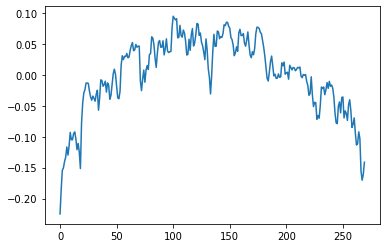

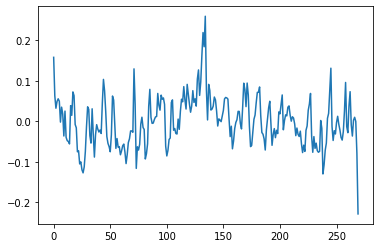

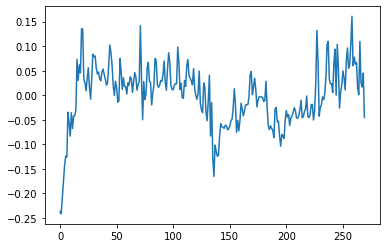

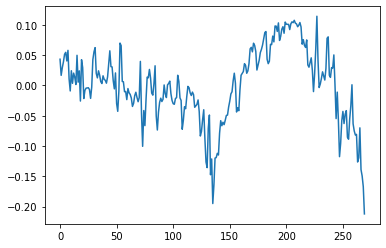

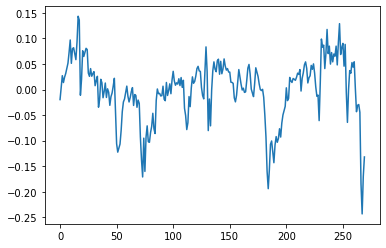

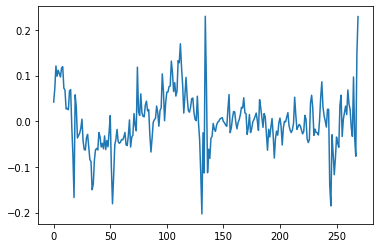

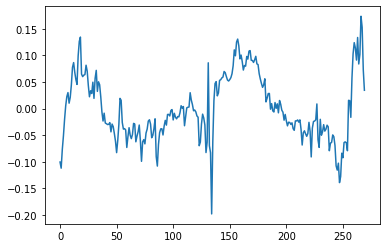

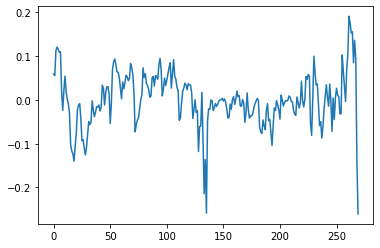

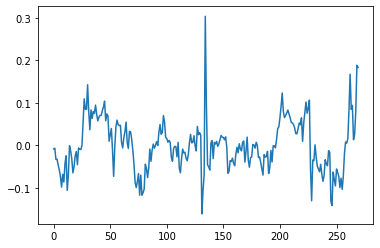

In [14]:
import matplotlib.pyplot as plt
from pandas import read_csv

components = read_csv(output_dir + '/mean_func/components.txt', index_col=None, delimiter='\t')

for comp in components.columns:
    plt.figure()
    plt.plot(components[comp])
    plt.show()
    plt.close()

## Movement Noise Evaluation Workflow

The nodes and workflow below (eval_noise_flow) is designed to take the nuissance regressors created in the previous section (create_noise_flow) and perform voxel-specific assessment of noise.  This is accomplished through the following steps:
1. Create unique design matrix for each 3D voxel
2. Perform a GLM for that voxel
3. Project results back into 3D space

In [44]:
sub_files_template={'motion': output_dir + '/motion_parameters/{subject_id}/_realign{runnum}/rest_moco.nii.gz.par', 
                    'leadlagderivsmotion': output_dir + '/leadlagderivsmotion/{subject_id}/_prep_motion{runnum}/derivsleadlag.txt', 
                    'leadlagderivs_squaremotion': output_dir + '/leadlagderivs_squaremotion/{subject_id}/_prep_motion{runnum}/derivssqleadlag.txt', 
                    'func': output_dir + '/registered_func/{subject_id}/_xfmFUNC{runnum}/realigned_func.nii.gz'}
select_sub_files=Node(SelectFiles(sub_files_template),name='select_sub_files')
select_sub_files.iterables=('runnum',['0','1','2'])

In [45]:
def org_shared_noise(motion, leadlagderivsmotion, leadlagderivs_squaremotion):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import loadtxt, concatenate
    from pandas import DataFrame
    from os.path import abspath
    
    noise_list = []
    for file in [motion, leadlagderivsmotion, leadlagderivs_squaremotion]:
        mo = loadtxt(file, dtype=float, comments=None)
        length_of_file = mo.shape[0]
        noise_list.append(mo)

    shared_noise_data = concatenate(noise_list,axis=1)
    
    col_names = ['noise_{0}'.format(a) for a in range(0,shared_noise_data.shape[1])] 
    
    shared_noise = DataFrame(shared_noise_data, columns=col_names)
    shared_noise.to_csv('shared_noise.csv')
    shared_noise_file = abspath('shared_noise.csv')
    return(shared_noise_file)

def voxelwise_p_eta(func,shared_noise_file,mean_func,mask):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from pandas import read_csv, DataFrame
    import numpy as np
    from nilearn.masking import apply_mask, unmask
    import numba
    from numba import jit
    
    # import data into an array that is timepoints (rows) by voxel number (columns)
    shared_noise = read_csv(shared_noise_file, index_col=0)
    shared_noise['constant'] = 1
    noise_mat = shared_noise.to_numpy()
    func_data = apply_mask(func, mask)
    mean_func_data = apply_mask(mean_func, mask)
    mean_func_data = mean_func_data[:func_data.shape[0],:]
    coefficients = np.zeros((noise_mat.shape[1]+1,func_data.shape[1]))
    num_regress_groups = int((noise_mat.shape[1]-7)/4)
    p_eta_data = np.zeros((num_regress_groups,func_data.shape[1]))
    
    @jit(nopython=True)
    def p_eta_parallel(p_eta_data,num_regress_groups,coefficients,mean_func_data,func_data,noise_mat):
        # perform voxel-wise matrix inversion 
        for x in range(0,func_data.shape[1]):
            noise_mat_new=np.column_stack((noise_mat,mean_func_data[:,x]))
            y = func_data[:,x].astype(np.float64)
            solution = np.linalg.lstsq(noise_mat_new,y)
            coefficients[:,x] = solution[0]
            r2 = np.mean(1 - np.dot(noise_mat_new,solution[0]) / (noise_mat_new.shape[0] * y.var()))
            for i in range(0,num_regress_groups):
                temp_mat = np.column_stack((noise_mat_new[:,:4*i+6],noise_mat_new[:,4*i+10:]))
                temp_sol = np.linalg.lstsq(temp_mat,y)
                temp_r2 = np.mean(1 - np.dot(temp_mat,temp_sol[0]) / (temp_mat.shape[0] * y.var()))
                p_eta_data[i,x] = r2-temp_r2  
        return(coefficients,p_eta_data,noise_mat_new)
    
    coefficients,p_eta_data,noise_mat_new = p_eta_parallel(p_eta_data,num_regress_groups,coefficients,mean_func_data,func_data,noise_mat)
    
    shared_noise_new = DataFrame(noise_mat_new, columns =shared_noise.columns.to_list() +['mean'], index=shared_noise.index)
    coeff_image = unmask(coefficients, mask)
    coeff_image.to_filename('weights.nii.gz')
    p_eta_image = unmask(p_eta_data, mask)
    p_eta_image.to_filename('p_eta.nii.gz')
    sample_design_df = shared_noise.to_csv('last_noise_mat.csv')

    weights = abspath('weights.nii.gz')
    p_eta = abspath('p_eta.nii.gz')
    sample_design_df = abspath('last_noise_mat.csv')
    return(weights,p_eta, sample_design_df)

In [46]:
compile_noise_mat = Node(Function(input_names=['motion', 'leadlagderivsmotion', 'leadlagderivs_squaremotion'],
                                  output_names=['shared_noise_file'],
                                  function=org_shared_noise), 
                         name='compile_noise_mat')
eval_noise_func = Node(Function(input_names=['func','shared_noise_file','mean_func','mask'], 
                                output_names=['weights','p_eta','sample_design_df'],
                                function=voxelwise_p_eta),
                       name='eval_noise_func')
eval_noise_func.inputs.mask = template_maskD1
eval_noise_func.inputs.mean_func = output_dir + '/mean_func/mean_funcs.nii.gz'

In [47]:
eval_noise_flow = Workflow(name='eval_noise_flow')
eval_noise_flow.connect([(infosource, select_sub_files,[('subject_id','subject_id')]),
                         (select_sub_files, eval_noise_func, [('func','func')]),
                         (select_sub_files, compile_noise_mat, [('motion','motion'),
                                                                ('leadlagderivsmotion','leadlagderivsmotion'), 
                                                                ('leadlagderivs_squaremotion','leadlagderivs_squaremotion')]),
                         (compile_noise_mat, eval_noise_func, [('shared_noise_file','shared_noise_file')]),
                         
                         (compile_noise_mat, datasink, [('shared_noise_file','shared_noise_file')]),
                         (eval_noise_func,datasink,[('weights','denoising_weights'),
                                                    ('sample_design_df','denoise_sample_design_df'),
                                                    ('p_eta','p_eta')])
                        ])
eval_noise_flow.base_dir = workflow_dir
eval_noise_flow.write_graph(graph2use='flat')
eval_noise_flow.run('MultiProc', plugin_args={'n_procs': 3})

191210-10:56:09,974 nipype.workflow INFO:
	 Generated workflow graph: /home/camachocm2/Analysis/SEA/rest_proc/workflows/eval_noise_flow/graph.png (graph2use=flat, simple_form=True).
191210-10:56:09,985 nipype.workflow INFO:
	 Workflow eval_noise_flow settings: ['check', 'execution', 'logging', 'monitoring']
191210-10:56:10,33 nipype.workflow INFO:
	 Running in parallel.
191210-10:56:10,36 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 56.55/56.55, Free processors: 3/3.
191210-10:56:10,263 nipype.workflow INFO:
	 [Node] Setting-up "eval_noise_flow.select_sub_files" in "/home/camachocm2/Analysis/SEA/rest_proc/workflows/eval_noise_flow/_subject_id_1096/_runnum_2/select_sub_files".
191210-10:56:10,266 nipype.workflow INFO:
	 [Node] Setting-up "eval_noise_flow.select_sub_files" in "/home/camachocm2/Analysis/SEA/rest_proc/workflows/eval_noise_flow/_subject_id_1096/_runnum_1/select_sub_files".
191210-10:56:10,305 nipype.workflow INFO:
	 [Node] Running

Process ForkProcess-25:
Process ForkProcess-26:
Process ForkProcess-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/local/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/local/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:


KeyboardInterrupt: 

  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/local/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
KeyboardInterrupt
  File "/usr/local/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr/local/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt

### Assess which motion parameters are associated with systematic noise

In [ ]:
# create mean of the parameter estimates for the noise variables
from subprocess import check_call
from glob import glob
files_to_avg = glob(output_dir + '/denoising_weights/*/*/weights.nii.gz')
check_call(['3dMean','-prefix',output_dir + '/mean_weights/mean_noise_estimates.nii.gz','-non_zero'] +files_to_avg)

files_to_avg = glob(output_dir + '/p_eta/*/*/p_eta.nii.gz')
check_call(['3dMean','-prefix',output_dir + '/mean_partial_r2/mean_p_eta_estimates.nii.gz','-non_zero'] +files_to_avg)

In [ ]:
from nilearn.masking import apply_mask
import matplotlib.pyplot as plt
from numpy import mean

p_eta_data = apply_mask(output_dir + '/mean_partial_r2/mean_p_eta_estimates.nii.gz', template_gmmask)
mean_p_etas = mean(p_eta_data, axis=1)

print(mean_p_etas)
plt.plot(mean_p_etas)

In [48]:
indices_to_drop = [1,3,5,7,9,11,12,13,14,15,16,17,18,19,20,21,22,23]

noise_to_drop = []
for i in indices_to_drop:
    noise_to_drop.append('noise_{0}'.format(4*i+6))
    noise_to_drop.append('noise_{0}'.format(4*i+7))
    noise_to_drop.append('noise_{0}'.format(4*i+8))

## Final Denoising Workflow

In [49]:
sub_files_template={'func': output_dir + '/registered_func/{subject_id}/_xfmFUNC{runnum}/realigned_func.nii.gz',
                    'motion': output_dir + '/motion_parameters/{subject_id}/_realign{runnum}/rest_moco.nii.gz.par', 
                    'leadlagderivsmotion': output_dir + '/leadlagderivsmotion/{subject_id}/_prep_motion{runnum}/derivsleadlag.txt', 
                    'leadlagderivs_squaremotion': output_dir + '/leadlagderivs_squaremotion/{subject_id}/_prep_motion{runnum}/derivssqleadlag.txt',
                    'session_noise':  output_dir + '/session_noise_file/{subject_id}/_session_noise{runnum}/blurred_masked_file.nii.gz',
                    'wmcsf_noise':  output_dir + '/wmcsf_noise_file/{subject_id}/_wmcsf_noise{runnum}/blurred_masked_file.nii.gz',
                    'motion':output_dir + '/motion_parameters/{subject_id}/_realign{runnum}/rest_moco.nii.gz.par'}
select_sub_files=Node(SelectFiles(sub_files_template),name='select_sub_files')
select_sub_files.iterables=('runnum',['0','1','2'])

In [50]:
def org_shared_noise(motion, leadlagderivsmotion, leadlagderivs_squaremotion):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import loadtxt, concatenate
    from pandas import DataFrame
    from os.path import abspath
    
    noise_list = []
    for file in [motion, leadlagderivsmotion, leadlagderivs_squaremotion]:
        mo = loadtxt(file, dtype=float, comments=None)
        length_of_file = mo.shape[0]
        noise_list.append(mo)

    shared_noise_data = concatenate(noise_list,axis=1)
    
    col_names = ['noise_{0}'.format(a) for a in range(0,shared_noise_data.shape[1])] 
    
    shared_noise = DataFrame(shared_noise_data, columns=col_names)
    shared_noise.to_csv('shared_noise.csv')
    shared_noise_file = abspath('shared_noise.csv')
    return(shared_noise_file)

def voxelwise_glm(func,shared_noise_file,mean_func,mask,noise_to_drop,session_noise,wmcsf_noise):
    from os.path import abspath
    from numpy import zeros, dot
    from numpy.linalg import lstsq
    from pandas import read_csv, Series
    from nilearn.masking import apply_mask, unmask

    shared_noise = read_csv(shared_noise_file, index_col=0)
    shared_noise.drop(labels=noise_to_drop, inplace=True, axis=1)
    
    # import data into an array that is timepoints (rows) by voxel number (columns)
    func_data = apply_mask(func, mask)
    wmcsf_data = apply_mask(wmcsf_noise, mask)
    session_data = apply_mask(session_noise, mask)
    mean_func_data = apply_mask(mean_func, mask)
    mean_func_data = mean_func_data[:func_data.shape[0],:]
    
    #preallocate matrices for output data
    coefficients = zeros((shared_noise.shape[1]+4,func_data.shape[1]))
    resid_data = zeros(func_data.shape)

    # perform voxel-wise matrix inversion
    for x in range(0,func_data.shape[1]):
        shared_noise['mean_signal'] = mean_func_data[:,x]
        shared_noise['wmcsf_noise'] = wmcsf_data[:,x]
        shared_noise['session_noise'] = session_data[:,x]
        shared_noise['constant'] = 1
        noise_mat = shared_noise.to_numpy()
        y = func_data[:,x]
        solution = lstsq(noise_mat,y,rcond=None)
        coefficients[:,x] = solution[0]
        resid_data[:,x] = dot(noise_mat,solution[0])

    resid_image = unmask(resid_data, mask)
    resid_image.to_filename('residuals.nii.gz')

    coeff_image = unmask(coefficients, mask)
    coeff_image.to_filename('weights.nii.gz')
    sample_design_df = shared_noise.to_csv('last_noise_mat.csv')

    weights = abspath('weights.nii.gz')
    sample_design_df = abspath('last_noise_mat.csv')
    residuals = abspath('residuals.nii.gz')

    return(weights,sample_design_df, residuals)

def censor_interp(in_file,mask,motion):
    from os.path import abspath
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.masking import apply_mask, unmask
    import numpy as np
    from pandas import DataFrame

    func_data = apply_mask(in_file,mask)

    motion_params = np.loadtxt(motion)
    motion_params[:,:3] = motion_params[:,:3]*50 #convert radians to mm
    motion_derivs = np.gradient(motion_params, axis=0)
    fd = np.sum(np.absolute(motion_derivs),axis=1)
    fd[0] = 0

    func_data[fd>0.25] = np.nan
    # put func data into pandas datafrmae to make interpolation easier/faster
    func_data_df = DataFrame(func_data)
    interp_func_df = func_data_df.interpolate(limit_direction='both')

    interp_func = interp_func_df.to_numpy()
    interp_func_img = unmask(interp_func, mask)
    interp_func_img.to_filename('interpolated_func.nii.gz')
    interpolated_func = abspath('interpolated_func.nii.gz')
    return(interpolated_func)

def drop_high_motion_trs(in_file, mask, motion):
    from os.path import abspath
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.masking import apply_mask, unmask
    import numpy as np

    motion_params = np.loadtxt(motion)
    motion_params[:,:3] = motion_params[:,:3]*50 #convert radians to mm
    motion_derivs = np.gradient(motion_params, axis=0)
    fd = np.sum(np.absolute(motion_derivs),axis=1)
    fd[0] = 0
    
    func_data = apply_mask(in_file,mask)
    lomo_func = func_data[fd<0.25]
    lomo_image = unmask(lomo_func,mask)
    lomo_image.to_filename('lomo_func.nii.gz')
    out_file = abspath('lomo_func.nii.gz')
    
    return(out_file)

In [51]:
compile_noise_mat = Node(Function(input_names=['motion', 'leadlagderivsmotion', 'leadlagderivs_squaremotion'],
                                  output_names=['shared_noise_file'],
                                  function=org_shared_noise), 
                         name='compile_noise_mat')

denoise_func = Node(Function(input_names=['func','shared_noise_file','mean_func','mask','noise_to_drop','session_noise','wmcsf_noise'], 
                             output_names=['weights','sample_design_df','residuals'],
                             function=voxelwise_glm),
                       name='denoise_func')
denoise_func.inputs.mask = template_maskD1
denoise_func.inputs.mean_func = output_dir + '/mean_func/mean_funcs.nii.gz'
denoise_func.inputs.noise_to_drop = noise_to_drop

censor_interpolate = Node(Function(input_names=['in_file','mask','motion'],
                                   output_names=['interpolated_func'], 
                                   function=censor_interp), 
                          name='censor_interpolate')
censor_interpolate.inputs.mask = template_gmmask

bandpass = Node(Bandpass(highpass=highpass_freq,
                         lowpass=lowpass_freq, 
                         out_file='resids_bp.nii.gz'), 
                name='bandpass')

drop_himo = Node(Function(input_names=['in_file','mask','motion'], 
                          output_names=['out_file'], 
                          function=drop_high_motion_trs), 
                 name='drop_himo')
drop_himo.inputs.mask = template_gmmask

In [ ]:
denoise_flow = Workflow(name='denoise_flow')
denoise_flow.connect([(infosource, select_sub_files,[('subject_id','subject_id')]),
                      (select_sub_files, censor_interpolate, [('motion','motion')]),
                      (select_sub_files, drop_himo,[('motion','motion')]),
                      (select_sub_files, compile_noise_mat, [('motion','motion'),
                                                             ('leadlagderivsmotion','leadlagderivsmotion'), 
                                                             ('leadlagderivs_squaremotion','leadlagderivs_squaremotion')]),
                      (compile_noise_mat, denoise_func, [('shared_noise_file','shared_noise_file')]),
                      (select_sub_files, denoise_func, [('func','func'),
                                                        ('session_noise','session_noise'),
                                                        ('wmcsf_noise','wmcsf_noise')]),
                      (denoise_func,censor_interpolate,[('residuals','in_file')]),
                      (censor_interpolate, bandpass, [('interpolated_func','in_file')]),
                      (bandpass, drop_himo, [('out_file','in_file')]),
                      
                      (drop_himo,datasink,[('out_file','fully_processed_func')]),
                      (denoise_func,datasink,[('weights','denoising_weights'),
                                              ('sample_design_df','denoise_sample_design_df')])
                     ])
denoise_flow.base_dir = workflow_dir
denoise_flow.write_graph(graph2use='flat')
denoise_flow.run('MultiProc', plugin_args={'n_procs': 3})

In [53]:
from glob import glob
import shutil
from subprocess import check_call

for sub in subjects_list:
    files = glob(output_dir + '/fully_processed_func/{0}/*/lomo_func.nii.gz'.format(sub))
    if len(files)==1:
        shutil.move(files[0],output_dir + '/fully_processed_func/{0}/final_proc_func.nii.gz'.format(sub))
    elif len(files)>1:
        check_call(['fslmerge','-t',output_dir + '/fully_processed_func/{0}/final_proc_func.nii.gz'.format(sub)]+files)
    else:
        print(sub + ' has not data!')

In [55]:
## Print list of unusable subjects (subs with <5 min of usable data)
min_num_trs = 300/TR
from nilearn.masking import apply_mask
results_file = open(output_dir + '/usability_report_final.csv','w')
results_file.write('subject,usable_trs,usable_minutes \n')

for sub in subjects_list:
    func = output_dir + '/fully_processed_func/{0}/final_proc_func.nii.gz'.format(sub)
    data = apply_mask(func,template_gmmask)
    if data.shape[0]<min_num_trs:
        print(sub + ' did NOT pass QC! Only {0} volumes ({1} minutes) were usable.'.format(data.shape[0],data.shape[0]*TR/60))
        results_file.write('{0},{1},{2} \n'.format(sub,data.shape[0],data.shape[0]*TR/60))
    else:
        print(sub + ' passed with {0} usable volumes or {1} minutes.'.format(data.shape[0],data.shape[0]*TR/60))
        results_file.write('{0},{1},{2} \n'.format(sub,data.shape[0],data.shape[0]*TR/60))
results_file.close()

1011 passed with 304 usable volumes or 7.144 minutes.
1017 passed with 508 usable volumes or 11.937999999999999 minutes.
1022 passed with 499 usable volumes or 11.726499999999998 minutes.
1024 passed with 492 usable volumes or 11.562 minutes.
1027 passed with 527 usable volumes or 12.3845 minutes.
1029 passed with 536 usable volumes or 12.596 minutes.
1034 passed with 490 usable volumes or 11.514999999999999 minutes.
1039 passed with 521 usable volumes or 12.243500000000001 minutes.
1041 passed with 489 usable volumes or 11.4915 minutes.
1043 passed with 292 usable volumes or 6.861999999999999 minutes.
1050 passed with 463 usable volumes or 10.8805 minutes.
1051 passed with 477 usable volumes or 11.209499999999998 minutes.
1053 passed with 523 usable volumes or 12.2905 minutes.
1054 passed with 506 usable volumes or 11.890999999999998 minutes.
1055 passed with 607 usable volumes or 14.2645 minutes.
1056 passed with 490 usable volumes or 11.514999999999999 minutes.
1057 passed with 485 